# Monte Carlo Simulation Tests Demo 


### 📘 Note

This notebook is dedicated to **Aleck**.  
If you have any questions or need clarification, feel free to reach out:  
📧 **simpsonz1227@gmail.com**  
🔗 [LinkedIn](www.linkedin.com/in/hongjia-zhang)

This is a demostration of permutation generation and Monte Carlo testing.


## Permutation demo

### Example 1: start with a simple example of generating permutations

In [14]:
#import packages 
from permutations import *
import numpy as np
import matplotlib.pyplot as plt

In [4]:
arrary = [0,1,2,3,4,5,6,7,8,9]
for i in range(10): #how many permutations we want to generate
    print(permutation_member(arrary.copy()))

[0, 2, 3, 9, 1, 6, 4, 7, 8, 5]
[0, 4, 8, 9, 6, 2, 1, 7, 3, 5]
[8, 9, 0, 6, 1, 3, 4, 2, 7, 5]
[4, 7, 5, 2, 0, 9, 1, 8, 3, 6]
[9, 6, 4, 0, 7, 8, 3, 2, 5, 1]
[0, 6, 9, 3, 2, 7, 4, 1, 5, 8]
[3, 7, 5, 0, 4, 2, 8, 1, 9, 6]
[9, 6, 5, 8, 4, 0, 3, 2, 7, 1]
[8, 7, 3, 4, 5, 1, 2, 6, 9, 0]
[8, 7, 3, 2, 9, 6, 1, 4, 5, 0]


This demonstrates how to generate random permutations of an array.

### Example 2: let's load some ohlcv data and permute the bars

                              open     high      low    close      volume
datetime                                                                 
2020-01-01 00:00:00+00:00  7189.43  7260.43  7170.15  7197.57   56801.329
2020-01-02 00:00:00+00:00  7197.57  7209.59  6922.00  6962.04  115295.677
2020-01-03 00:00:00+00:00  6962.34  7407.28  6863.44  7341.72  208493.458
2020-01-04 00:00:00+00:00  7341.60  7400.00  7269.21  7350.71   92586.033
2020-01-05 00:00:00+00:00  7350.54  7495.00  7303.00  7354.36  117765.972


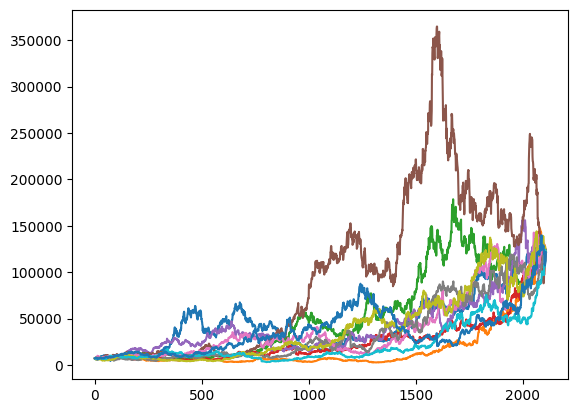

In [5]:
import pickle

# a utility function to load pickle file that I provided
def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
    
ohlcvs = load_pickle('ohlcvs.pickle') # it includes a list of 4 dataframes with each dataframe representing daily ohlcv data of a crypto asset as an example
print(ohlcvs[0].head()) # a snapshot of the data for the first asset
prices = [ohlcvs[0]['close'].values]
for i in range(10):
    prices.append(
        permute_price(
            price = ohlcvs[0]['close'].values
        )
    )
prices = pd.DataFrame(prices).T
plt.plot(prices)
plt.show()

This demonstrates how to permute the closing prices of a single asset and visualise the permutations.


It is difficult to tell which one is the real price and which ones are the permuted ones.


It is a **good** thing as the permuted prices should look realistic.

### Example 3 : let's permute asset bars (open, high, low, close, volume) data

It is very tricky to permute OHLCV data while keeping the bar structure valid, because we need to keep both **inter-bar** and **intra-bar** relationships valid.


- Inter-bar relationship means the open price of a bar is or similar to the close price of the previous bar.
- Intra-bar relationship means the open, high, low, close prices of a bar should maintain their relative order. 
    - Without intra-bar relationship, we may end up with a bar that has a low price higher than the high price, which is invalid.

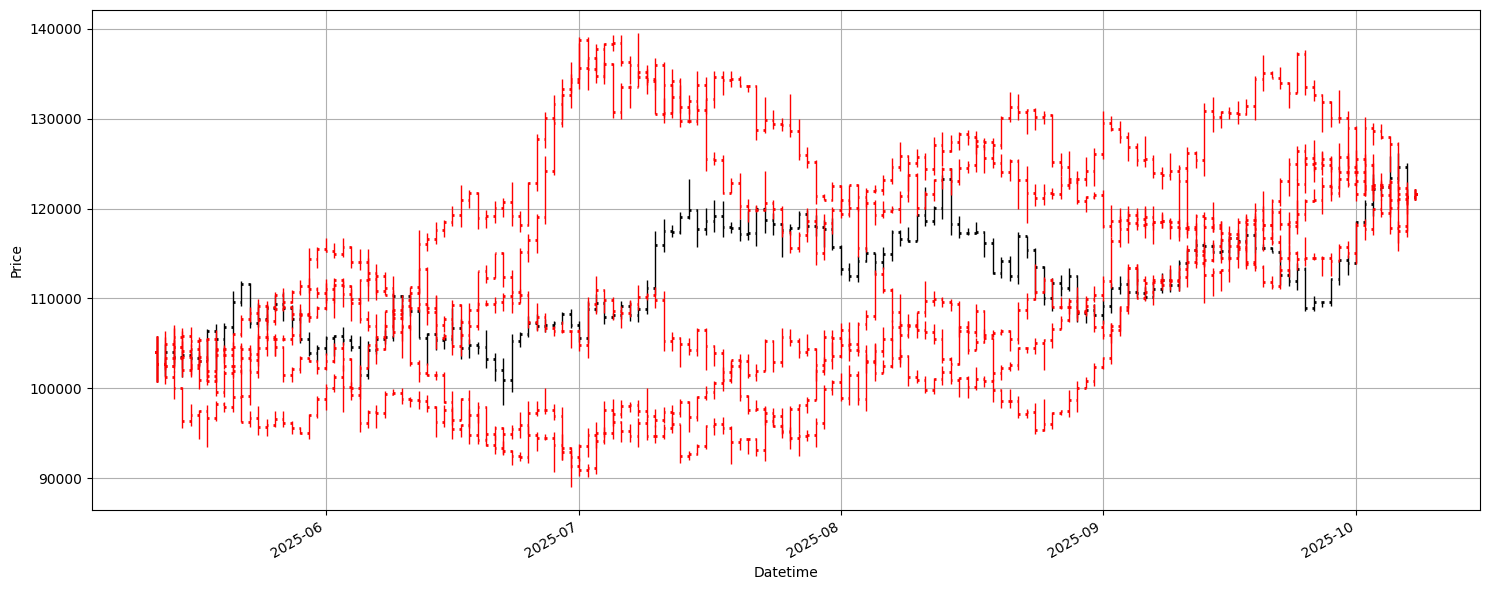

In [6]:
#we use only 150 data points for a quick demo
tail = 150
ohlcvs = [ohlcv.tail(tail) for ohlcv in ohlcvs]
bars = []
for i in range(5): # generate 5 permutations 
    bars.append(
        permute_bars(
            ohlcv = ohlcvs[0]
        )
    )
# we use the utility function from the permutations.py to plot japanese candles
plot_japanese_candles(ohlcvs[0], bars)

This demonstrates how to permute the OHLCV data of a single asset while maintaining valid bar structures.


The plot shows the original bars(in black) and the permuted bars(in red).




If you look closely at the individual bar characteristics, you will see that we maintain both inter-bar and intra-bar relationships.
1. e.g. the closing of one bar is exactly equal or very close to the opening of the next bar.
2. e.g. the high price is always higher than both the open and close prices, and the low price is always lower than both the open and close prices.


This is important for any Monte Carlo testing that involves OHLCV data.


If you use more data points (e.g. 700 rather than 150), it will look like a line chart as what we observed in Example 2.


It is very difficult to tell which one is the real price and which ones are the permuted ones -- **Good**!

### Example 4: let's permute multiple assets' OHLCV data together

It is important to note that, not all assets are alived at the same time. e.g. BTC may exist for 10 years, while SOL may exist for only 2 years.


If we permute them together, SOL may end up with some straight lines in the middle of the price chart.


So in the permute_multi_bars function, we **partition** the bars into **overlapping segments**.

- e.g. BTC exist from 2013 to 2024, ETH exist from 2015 to 2024, SOL exist from 2020 to 2024.
- Then the first permutation segment is from 2013 to 2015, which only includes BTC.
- The second permutation segment is from 2015 to 2020, which includes both BTC and ETH.
- The third permutation segment is from 2020 to 2024, which includes BTC, ETH, and SOL.


We then permute each segment separately and concatenate the results.


This way, we can keep the bar structure valid and also respect the asset alive time.

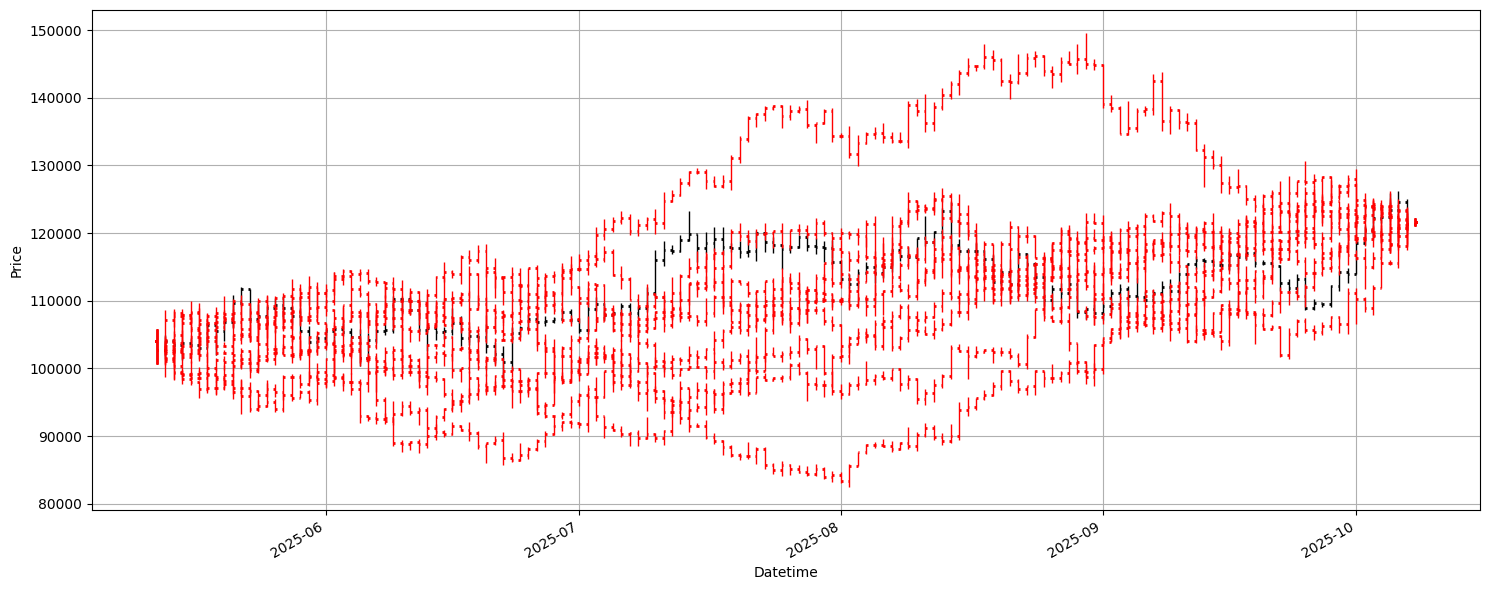

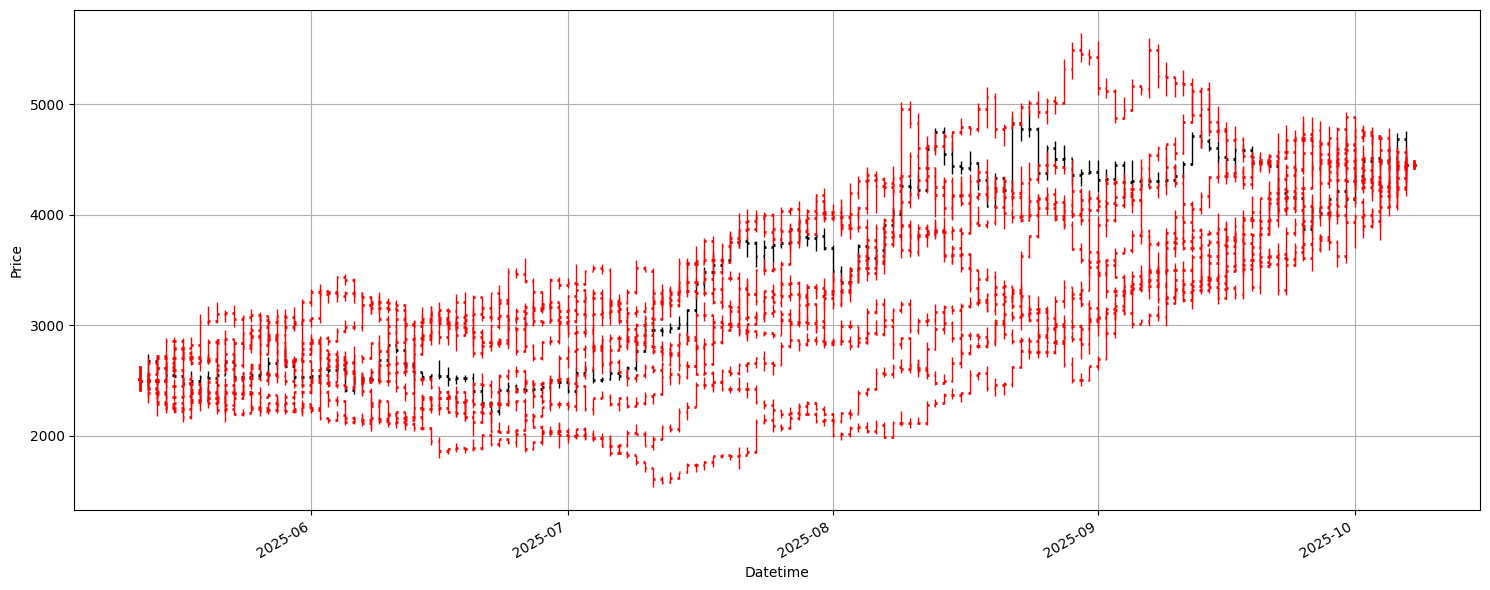

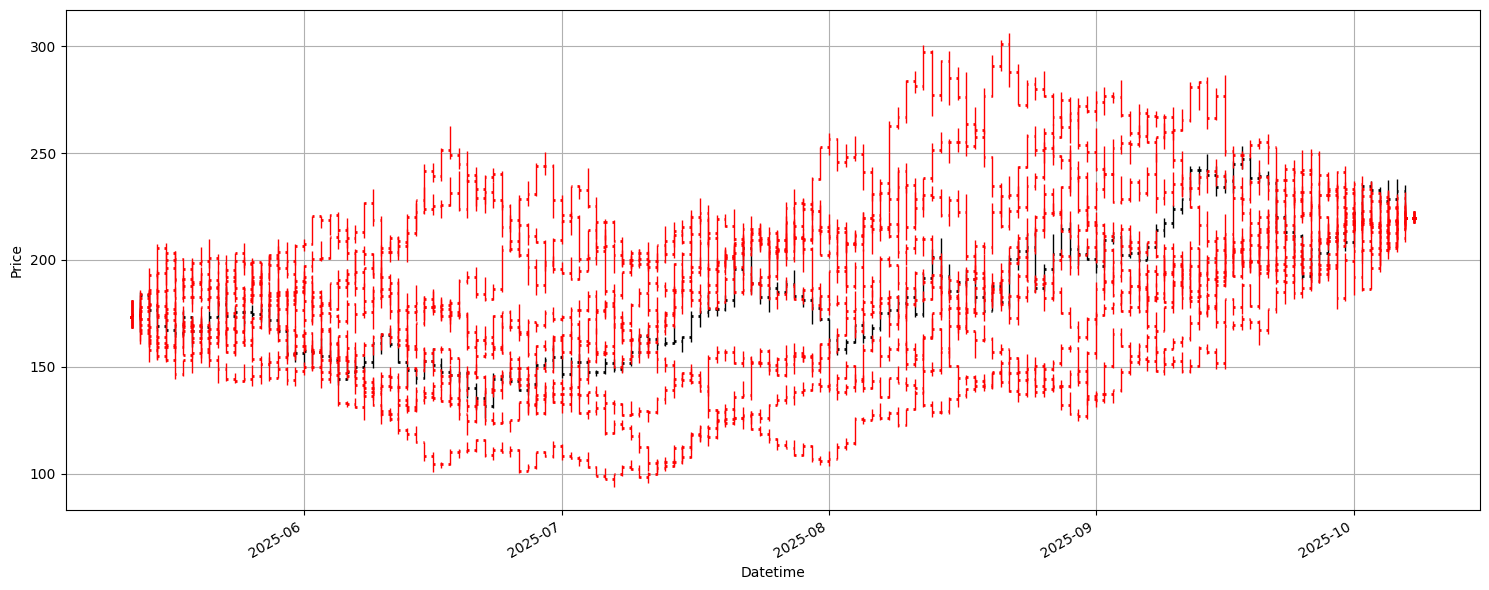

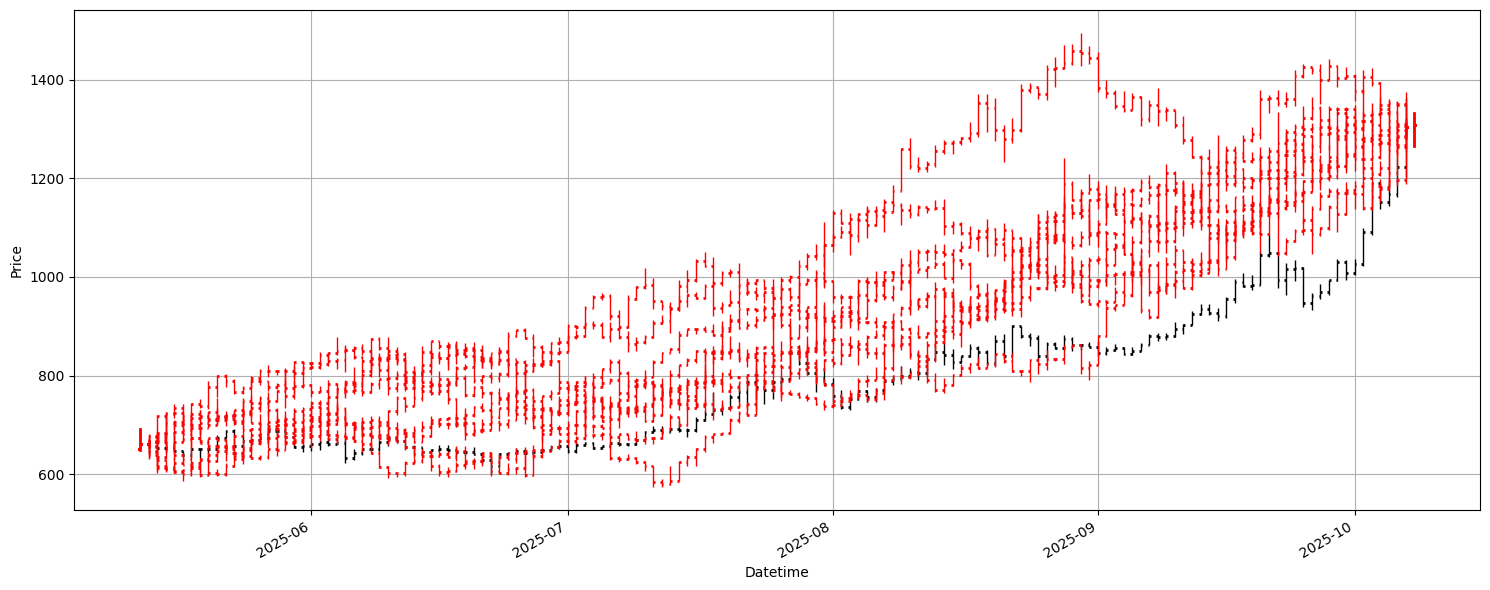

In [9]:

tail = 700
ohlcvs = [ohlcv.tail(tail) for ohlcv in ohlcvs]

k = 10
perms = [permute_multi_bars(ohlcvs) for _ in range(k)] # generate 10 permutations
for i, original in enumerate(ohlcvs):
    permuted_samples = [perm_j[i] for perm_j in perms]
    plot_japanese_candles(original, permuted_samples) # 4 plots for 4 assets

### Example 5: Monte Carlo testing of a trading strategy

In [12]:
from permutation_tests import *
 # the artefacts were generated from a backtest of a trading strategy, you should replace it with your own artefacts
artefacts = load_pickle('artefacts.pickle')
print("*" * 80)
print("The artefacts loaded:")
print(artefacts)
print("*" * 80)
retdf = artefacts['ret_df']
weights = artefacts['weights']
leverages = artefacts['leverages']
eligibles = artefacts['eligibles']
capital_ret = artefacts['capital_ret']

sample_sharpe = metric(levs = leverages, rets = retdf, weights = weights)
print(f'sample sharpe: {sample_sharpe}')

"""
Now we want to conduct the t-test on asset picking and asset timing abilities of the strategy.
"""
timer_p = permutation_shuffler_test(
    metric_func = metric,
    permuter = time_shuffler,
    M = 1000,
    levs = leverages,
    rets = retdf,
    weights = weights,
    eligibles = eligibles
)


picker_p = permutation_shuffler_test(
    metric_func = metric,
    permuter = time_shuffler,
    M = 1000,
    levs = leverages,
    rets = retdf,
    weights = weights,
    eligibles = eligibles  
)

print(f'timer p-value: {timer_p:.4g}, picker p-value: {picker_p:.4g}')

********************************************************************************
The artefacts loaded:
{'capital_ret': datetime
2019-09-22 00:00:00+00:00   -0.000625
2019-09-23 00:00:00+00:00    0.005053
2019-09-24 00:00:00+00:00    0.016542
2019-09-25 00:00:00+00:00    0.003755
2019-09-26 00:00:00+00:00    0.006420
                               ...   
2025-10-04 00:00:00+00:00   -0.009478
2025-10-05 00:00:00+00:00    0.007133
2025-10-06 00:00:00+00:00    0.019463
2025-10-07 00:00:00+00:00   -0.012695
2025-10-08 00:00:00+00:00   -0.006476
Name: capital_ret, Length: 2209, dtype: float64, 'ret_df':                            BTCUSDT r  ETHUSDT r  SOLUSDT r  BNBUSDT r
datetime                                                             
2019-09-22 00:00:00+00:00   0.003978   0.000000   0.000000   0.000000
2019-09-23 00:00:00+00:00  -0.032034   0.000000   0.000000   0.000000
2019-09-24 00:00:00+00:00  -0.108880   0.000000   0.000000   0.000000
2019-09-25 00:00:00+00:00  -0.024931   0.0000

The test suggests that the strategy has both timing and picking abilities since both p-values are very small. (timer p-value: 0.01698, picker p-value: 0.01299)


This demonstrates how to conduct Monte Carlo testing of a trading strategy using permutation tests.


This is the end of the permutation demo. 

## Monte Carlo Testing Demo 

### Example 6: now we want to implement the monte carlo testing on the entire bar data, rather than just the returns.

Now we want to conduct the t-test on the entire bar data rather than just return series. 

We want to figure out taking into account of the **full bar data(OHLCV)**, whether my trading strategy’s Sharpe ratio genuinely **good**, or could such performance have happened just by _luck_ if the same returns were randomly shuffled in time?

- H0:The trading strategy’s Sharpe ratio is **no better** than what could occur by random chance, given the same daily return structure.


- H1:The observed Sharpe ratio is **significantly higher** than would be expected by chance. The strategy exploits real temporal structure or predictive relationships in the data.

**Important Note**: in the section, you won't be able to run the code directly as I have not provided the full strategy implementation.

You can implement your own strategy and add this part to your strategy testing.

If you understand the code above and the code below, you should be able to implement it easily.

Any question, please contact me at simpsonz1227@gmail.com


In [13]:
"""M = 100
null_sharpes = []
simdfs = [bollinger_df]
for i in range(M): 
    bars =  permute_multi_bars(ohlcvs) # generate permuted bars for all assets
    bollinger.dfs = {ticker:bar for ticker, bar in zip(tickers,bars)} # we use the generated permuted bars to run the strategy
    simdf = bollinger.run_simulation()
    simdfs.append(simdf)
    artefacts = bollinger.get_zero_filtered_stats() # get the artefacts from the strategy
    null_sharpe = metric(
        levs = artefacts['leverages'],
        rets = artefacts['ret_df'],
        weights = artefacts['weights']
    )
    null_sharpes.append(null_sharpe)
k = sum(1 for ns in null_sharpes if ns >= sample_sharpe)
trader_p = (1+k) / (M+1)
print(f'sample sharpe from real data: {sample_sharpe}, trader p-value: {trader_p:.4g}')
plotfigs(simdfs, nonrandom = 1) """

"M = 100\nnull_sharpes = []\nsimdfs = [bollinger_df]\nfor i in range(M): \n    bars =  permute_multi_bars(ohlcvs) # generate permuted bars for all assets\n    bollinger.dfs = {ticker:bar for ticker, bar in zip(tickers,bars)} # we use the generated permuted bars to run the strategy\n    simdf = bollinger.run_simulation()\n    simdfs.append(simdf)\n    artefacts = bollinger.get_zero_filtered_stats() # get the artefacts from the strategy\n    null_sharpe = metric(\n        levs = artefacts['leverages'],\n        rets = artefacts['ret_df'],\n        weights = artefacts['weights']\n    )\n    null_sharpes.append(null_sharpe)\nk = sum(1 for ns in null_sharpes if ns >= sample_sharpe)\ntrader_p = (1+k) / (M+1)\nprint(f'sample sharpe from real data: {sample_sharpe}, trader p-value: {trader_p:.4g}')\nplotfigs(simdfs, nonrandom = 1) "

After 100 times simulation, this is what we get visually and the output results:


![Permutation Results](permutation_test_results.png)

Here are our output results:

sample sharpe from real data: 0.938, trader p-value: 0.0396

Our strategy performance is fairly well as it is statistically significant at the 5% level.

This means our strategy's (we applied a momentum strategy here) performance is **statistically significant** , rather than just be random luck ! 